# 保険詐欺検出モデル Fraud Detection Model

## 1. 目的と背景
詐欺的な保険請求を検出することで、コスト削減とリスク回避を目指します。

## 2. データの確認・前処理
- データセットの構成・クラス分布の確認  
- カテゴリ変数へのLabel Encodingの実施

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder

# CSVファイルを読み込み
df = pd.read_csv(r'C:\Users\okada\fraud_oracle.csv')

# データセットの先頭5行を表示して内容を確認
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [2]:
# 各列に欠損値（null値）がいくつあるかを集計して表示
print(df.isnull().sum())

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64


In [3]:
# 'FraudFound_P'列に含まれる値（0と1）の出現回数を集計して確認
df['FraudFound_P'].value_counts()

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [4]:
# 各列のデータ型（int, float, objectなど）を確認
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [5]:
# 目的変数を除く、データ型が'object'の列の抽出 
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# カテゴリ変数の列名リストの表示  
print("List of categorical columns:")
print(categorical_cols)

List of categorical columns:
['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']


In [6]:
from sklearn.preprocessing import OneHotEncoder

# 不必要な列の削除  
df = df.drop(['PolicyNumber', 'RepNumber'], axis=1)

# 'WeekOfMonth'と'WeekOfMonthClaimed'のカテゴリ変数リストへの追加処理
for col in ['WeekOfMonth', 'WeekOfMonthClaimed']:
    if col not in categorical_cols:
        categorical_cols.append(col)

# カテゴリ変数の文字列型への変換
df[categorical_cols] = df[categorical_cols].astype(str)

# OneHotEncoderの初期化処理
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# カテゴリ変数に対するエンコード処理
encoded_array = ohe.fit_transform(df[categorical_cols])

# エンコード後の特徴量名の取得
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# エンコード結果のDataFrame化処理
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# 元のカテゴリ変数の削除とエンコード結果の結合処理
df_for_model = df.drop(columns=categorical_cols)
df_for_model = pd.concat([df_for_model, encoded_df], axis=1)

# 処理結果の確認用出力
df_for_model.head()

,Age,FraudFound_P,Deductible,DriverRating,Year,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,...,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,WeekOfMonthClaimed_1,WeekOfMonthClaimed_2,WeekOfMonthClaimed_3,WeekOfMonthClaimed_4,WeekOfMonthClaimed_5
0,21,0,300,1,1994,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,34,0,400,4,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47,0,400,3,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,65,0,400,2,1994,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,27,0,400,1,1994,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 3. ベースライン
### 3.1 単純な決定木
- 単体モデルとしてのベースライン評価  
- クラス不均衡への対応（class_weight）

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report

# 特徴量と目的変数への分割処理
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# 訓練データとテストデータへの分割処理
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# クラス不均衡に対応したサンプル重みの算出処理
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 決定木分類器の初期化処理 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# サンプル重みを用いたモデルの学習処理
dt_model.fit(X_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [8]:
# テストデータに対する予測結果の出力  
y_pred = dt_model.predict(X_test)

# 混同行列および分類レポートによるモデル評価 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1687 1200]
 [   7  190]]
              precision    recall  f1-score   support

           0       1.00      0.58      0.74      2887
           1       0.14      0.96      0.24       197

    accuracy                           0.61      3084
   macro avg       0.57      0.77      0.49      3084
weighted avg       0.94      0.61      0.70      3084



### 3.2 ランダムフォレスト
- クラス不均衡への対応(scale_pos_weight)

In [9]:
from sklearn.ensemble import RandomForestClassifier

# クラス不均衡に対応したランダムフォレスト分類器の初期化  
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# ランダムフォレストによるモデルの学習処理  
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [10]:
# テストデータに対する予測結果の出力
y_pred = rf_model.predict(X_test)

# 混同行列および分類レポートによるモデル評価
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2887    0]
 [ 195    2]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       1.00      0.01      0.02       197

    accuracy                           0.94      3084
   macro avg       0.97      0.51      0.49      3084
weighted avg       0.94      0.94      0.91      3084



### 3.3 XGBoost
- クラス不均衡への対応(scale_pos_weight)
- 閾値最適化(F1-score最大化)

ライブラリが未インストールの場合は以下を実行：  
pip install xgboost  
pip install scikit-learn

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# クラス不均衡比率の計算処理
negative = sum(y_train == 0)
positive = sum(y_train == 1)
scale = negative / positive

# クラス不均衡に対応したXGBoostモデルの学習処理
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # クラス不均衡に対する重みの設定
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
# テストデータに対する予測結果の出力
y_pred = xgb_model.predict(X_test)

# 混同行列および分類レポートによるモデル評価
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2112  775]
 [  37  160]]
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      2887
           1       0.17      0.81      0.28       197

    accuracy                           0.74      3084
   macro avg       0.58      0.77      0.56      3084
weighted avg       0.93      0.74      0.80      3084



### 3.4 モデル比較（評価指標＋グラフ）

In [13]:
# 評価対象となる学習済みモデルの辞書オブジェクト
models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_curve, 
    auc, 
    f1_score, 
    accuracy_score
)
import pandas as pd

# 評価指標の記録用リストオブジェクト
results = []

for name, model in models.items():
    # 予測確率および予測ラベルの取得処理
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率 
    y_preds = model.predict(X_test)              # クラスラベルの予測結果

    # 各種評価指標の計算処理
    roc_auc = roc_auc_score(y_test, y_probs)
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_preds)
    acc = accuracy_score(y_test, y_preds)

    # 評価結果の保存処理
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc,
    })

# 評価結果をデータフレーム形式に変換する処理
df_results = pd.DataFrame(results)
print(df_results)

           Model   ROC AUC    PR AUC  F1-score  Accuracy
0  Decision Tree  0.822782  0.229275  0.239445  0.608625
1  Random Forest  0.823494  0.285177  0.020101  0.936770
2        XGBoost  0.848002  0.281659  0.282686  0.736706


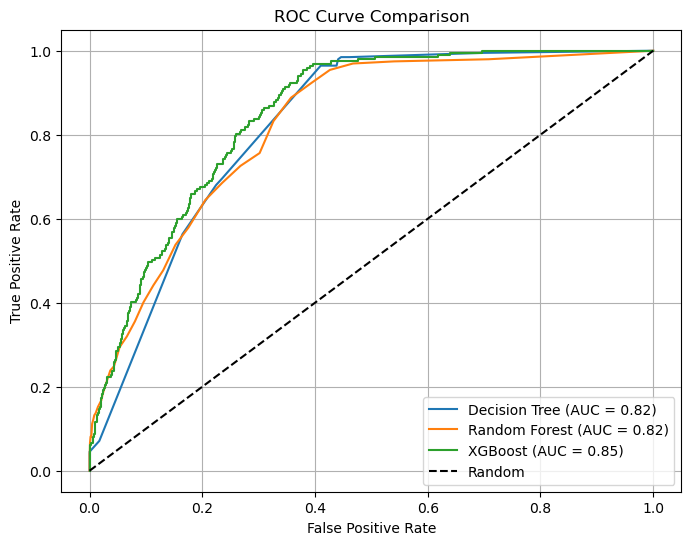

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# プロットのサイズ設定
plt.figure(figsize=(8,6))

# 各モデルに対するROC曲線の描画処理
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率
    fpr, tpr, _ = roc_curve(y_test, y_probs)     # 偽陽性率と真陽性率の取得処理
    roc_auc = roc_auc_score(y_test, y_probs)     # AUCスコアの算出処理
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")  # モデルごとの曲線描画

# ランダム分類器の基準線描画
plt.plot([0,1], [0,1], 'k--', label='Random')

# 軸ラベルの設定処理
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

# 凡例とグリッドの表示処理
plt.legend()
plt.grid(True)

# グラフの描画表示処理
plt.show()

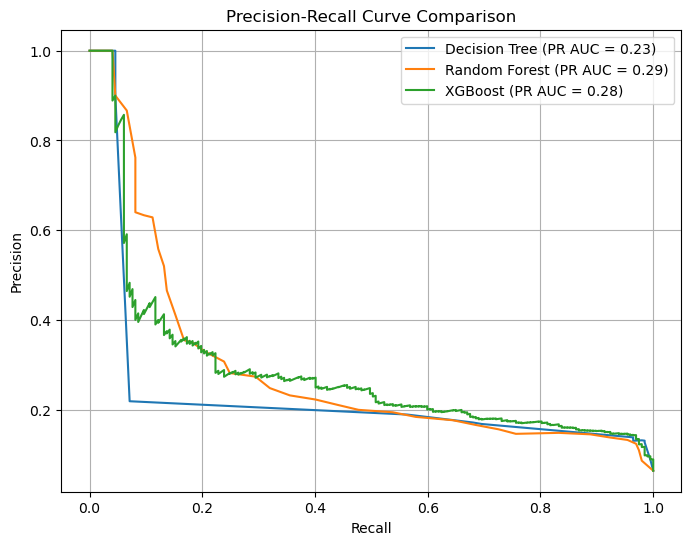

In [15]:
# プロットのサイズ設定
plt.figure(figsize=(8,6))

# 各モデルに対するPR曲線の描画処理
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]  # クラス1の予測確率
    precision, recall, _ = precision_recall_curve(y_test, y_probs)  # 適合率と再現率の取得処理
    pr_auc = auc(recall, precision)  # PR AUCスコアの算出処理
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")  # モデルごとの曲線描画

# 軸ラベルの設定処理
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")

# 凡例とグリッドの表示処理
plt.legend()
plt.grid(True)

# グラフの描画表示処理
plt.show()

## 4. 精度改善アプローチ
### 4.1 派生変数の追加

In [16]:
# 元データのコピーによる特徴量用データ作成処理
df_features = df_for_model.copy()

# 1. 事故日と請求日の差分日数の算出処理
# カテゴリ変数 'Days_Policy_Accident' と 'Days_Policy_Claim' を数値に変換する関数定義
def days_to_num(x):
    mapping = {
        'none': 0,
        '1 to 7': 4,
        '8 to 15': 12,
        '15 to 30': 22,
        'more than 30': 45
    }
    return mapping.get(x, -1)  # 未知の値には -1 を割り当てる処理

# 数値変換後の新しい列の追加処理
df['Days_Policy_Accident_Num'] = df['Days_Policy_Accident'].map(days_to_num)
df['Days_Policy_Claim_Num'] = df['Days_Policy_Claim'].map(days_to_num)

# 請求日と事故日の差分日数の新規特徴量作成処理
df_features['Days_Diff'] = df['Days_Policy_Claim_Num'] - df['Days_Policy_Accident_Num']

# 2. 若年ドライバーかどうかの判定処理（25歳未満なら1）
df_features['Is_YoungDriver'] = (df['Age'] < 25).astype(int)

# 特徴量と目的変数への分割処理
X = df_features.drop('FraudFound_P', axis=1)
y = df_features['FraudFound_P']

# トレーニングデータとテストデータへの分割処理
from sklearn.model_selection import train_test_split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostモデルの定義と学習処理（クラス不均衡に対応）
xgb_fe_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale,  # クラス不均衡への重み補正処理
    random_state=42,
    eval_metric='logloss'
)
xgb_fe_model.fit(X_train_fe, y_train_fe) # モデルの学習処理

# テストデータに対する予測処理
y_pred = xgb_fe_model.predict(X_test_fe)

# 混同行列と分類レポートの出力処理
print(confusion_matrix(y_test_fe, y_pred))
print(classification_report(y_test_fe, y_pred))

[[2079  808]
 [  38  159]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2887
           1       0.16      0.81      0.27       197

    accuracy                           0.73      3084
   macro avg       0.57      0.76      0.55      3084
weighted avg       0.93      0.73      0.80      3084



### 4.2 オーバーサンプリング

In [17]:
#!pip uninstall scikit-learn imbalanced-learn -y

In [18]:
#!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

In [19]:
#!conda install -c conda-forge scikit-learn=1.2.2 imbalanced-learn=0.10.1

In [20]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 説明変数と目的変数への分割処理
X = df_for_model.drop('FraudFound_P', axis=1)
y = df_for_model['FraudFound_P']

# トレーニングデータとテストデータへの分割処理
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE によるオーバーサンプリング処理（マイノリティクラスの合成データ生成処理）
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost モデルの学習処理（クラス重みは SMOTE により不要）
xgb_model_smote = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)
xgb_model_smote.fit(X_train_resampled, y_train_resampled)

# テストデータに対する予測処理
y_pred = xgb_model_smote.predict(X_test)

# 混同行列と分類レポートの出力処理
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2887    0]
 [ 190    7]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       1.00      0.04      0.07       197

    accuracy                           0.94      3084
   macro avg       0.97      0.52      0.52      3084
weighted avg       0.94      0.94      0.91      3084



### 4.3 閾値の最適化
すべてのモデルはデフォルトの閾値（0.5）で評価していますが、  
最も良いパフォーマンスを示したXGBoostに対してのみ、F1スコアを最大化するようにしきい値の最適化を行います。  
これにより、さらに性能を引き上げることができます。

In [21]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# 1. モデル定義と学習処理
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# 2. 予測確率の取得処理（クラス1に属する確率）
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. 複数のしきい値に対する F1 スコアの算出処理
thresholds = np.arange(0.0, 1.01, 0.01)  # 0.00〜1.00 を 0.01 刻みで生成
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)  # 指定閾値による予測結果
    f1 = f1_score(y_test, y_pred_thresh)        # F1 スコアの計算処理
    f1_scores.append(f1)                        # スコアの保存処理

# 4. 最も高い F1 スコアを出す閾値の取得処理
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# 5. 閾値を持つカスタムモデルクラスの定義処理
class XGBWithThreshold:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):  # 確率予測メソッド
        return self.model.predict_proba(X)

    def predict(self, X):  # カスタム閾値での予測メソッド
        probs = self.model.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

# 6. 最適な閾値を持つモデルの保存処理
xgb_model_threshold = XGBWithThreshold(xgb_model, best_threshold)

# 7. 最適な閾値に基づく予測と評価処理
y_pred_opt = xgb_model_threshold.predict(X_test)

# 混同行列と分類レポートの出力処理
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))

Best threshold for F1-score: 0.05
[[2301  586]
 [  48  149]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      2887
           1       0.20      0.76      0.32       197

    accuracy                           0.79      3084
   macro avg       0.59      0.78      0.60      3084
weighted avg       0.93      0.79      0.84      3084



### 4.4 モデル比較

In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
import pandas as pd

# モデルと名前のリスト
models = [
    ("XGBoost", xgb_model, X_test),                         # ベースラインモデル
    ("XGBoost_FE", xgb_fe_model, X_test_fe),                # 派生特徴量を加えたモデル
    ("XGBoost_SMOTE", xgb_model_smote, X_test),             # SMOTE適用済みモデル
    ("XGBoost_Threshold", xgb_model_threshold, X_test)      # 閾値調整モデル
]

# 評価結果の格納用リスト
results = []

for name, model, X_eval in models:
    # 確率予測の取得処理（閾値調整モデルは predict をオーバーライド済）
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = model.predict(X_eval)

    # 各種評価指標の計算処理
    roc_auc = roc_auc_score(y_test, y_pred_proba)                 # ROC AUCスコア
    pr_auc = average_precision_score(y_test, y_pred_proba)        # PR AUCスコア
    f1 = f1_score(y_test, y_pred)                                 # F1スコア
    acc = accuracy_score(y_test, y_pred)                          # 正解率（Accuracy）

    # 結果の追加処理
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "F1-score": f1,
        "Accuracy": acc
    })

# 結果をDataFrame形式で出力処理
results_df = pd.DataFrame(results)
print(results_df)

               Model   ROC AUC    PR AUC  F1-score  Accuracy
0            XGBoost  0.860446  0.289875  0.142857  0.937743
1         XGBoost_FE  0.852922  0.304544  0.273196  0.725681
2      XGBoost_SMOTE  0.847737  0.293285  0.068627  0.938392
3  XGBoost_Threshold  0.860446  0.289875  0.319742  0.794423


## 5. 考察
### 5.1 SHAPによる特徴量重要度の可視化
 
ライブラリが未インストールの場合は以下を実行：

pip install shap  
pip install -U scikit-learn

In [23]:
import shap

# SHAP値計算用の説明器（XGBoostなどの決定木系モデル用）
explainer = shap.TreeExplainer(xgb_model_threshold.model)

C:\Users\okada\anaconda3\envs\fraud-detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# SHAP値の計算
shap_values = explainer.shap_values(X_test)

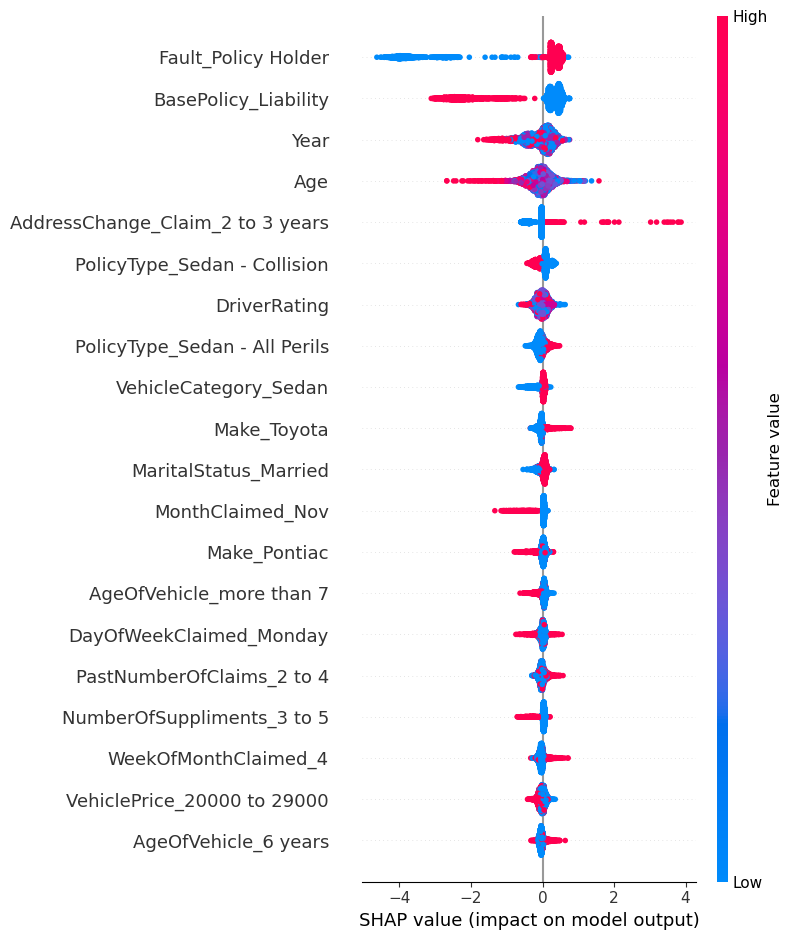

In [25]:
# サマリープロットの表示（グローバルな特徴量重要度）
shap.summary_plot(shap_values, X_test)

### 5.2 モデル精度の伸び悩み原因考察

モデル性能の伸び悩みの一因として、まずクラス不均衡の影響が挙げられる。詐欺件数は全体のごく一部にとどまり、その結果、モデルは非詐欺クラスに偏った予測を行いやすく、F1スコアの向上に限界が見られた。この課題に対処するためにSMOTEやしきい値の調整などを試みたが、PR AUCの改善は限定的であった。これは、データ中の詐欺パターンが多様で一貫性に欠けることや、ラベル付けの曖昧さ、さらには特徴量自体の情報量不足が影響していると考えられる。加えて、ターゲット変数（詐欺）の定義そのものが現実的に難しく、モデル学習におけるノイズ源となっている可能性もある。

## 6. 結論・ビジネス的示唆

本分析では、XGBoostを中心とした複数の機械学習手法を用いて保険詐欺の検出モデルを構築し、精度・再現率・PR AUCといった指標から比較・検証を行った。その結果、特徴量エンジニアリングやしきい値調整により一定の改善が見られたものの、クラス不均衡や詐欺パターンの多様性といった根本的な課題が精度向上の壁となった。

ビジネス的な側面としては、完全な自動化を目指すのではなく、モデルをファーストフィルターとして活用し、人間による判断を補助する形で運用することが現実的かつ有効と考えられる。また、今後はより多様なデータソース（位置情報、通話履歴、外部データ連携など）を組み合わせることで、より実用的な不正検出の仕組みを構築できる可能性がある。